In [1]:
import pandas as pd

df = pd.read_csv('cat_emails_v2.csv')

df.head()

,category,subject,email
0,Financing balance credit,Re: meines – Klärung notwendig,"Hallo,\n\nkönnen Sie mir bitte die Unterlagen ..."
1,Third party purchase,Re: rechnung – Klärung notwendig,"Sehr geehrtes Serviceteam,\n\nbitte bestätigen..."
2,Account clarification,"Re: Mehrere Anliegen (betrag, um, arag)","Sehr geehrte Damen und Herren,\n\nes geht nich..."
3,Follow-up Contract,"Re: Mehrere Anliegen (würde, https, pro)","Re: Offene Angelegenheiten\n\nHallo,\n\nwie be..."
4,Devinculation,Dringend: Bitte um Rückmeldung zu 06 03,"Hallo,\n\nkönnen Sie mir bitte die Unterlagen ..."


In [4]:
df['category'].unique()

array(['Financing balance credit', 'Third party purchase',
       'Account clarification', 'Follow-up Contract', 'Devinculation',
       'Credit item', 'Bank statement', 'Compensation release',
       'Call-back', 'Data extract', 'Complaint',
       'FB Lustum/ beneficial owner', 'Claims management',
       'General contract information',
       'Financing balance residual value leasing', 'Duplicate/KSV block',
       '1st Level Onlinetools', 'Policy/endorsement/cover', 'Unsubscribe',
       'HB & HBO', 'Vinculation', 'Insurance change',
       'Damage report/repair approval', 'Contract rewriting',
       'Contract adjustment', 'Insurance offer', 'Change customer data',
       'Cancellation', 'Change in payment transactions',
       'General enquiry/errors', 'Fuel card/maintenance', 'Calculations',
       'Sanierung ', 'Liability Insurer'], dtype=object)

Dataset has 34 labels so that classification would be multilabeled.

Imbalance Ratio: 2.69
Mean count: 147.06
Standard deviation: 30.52


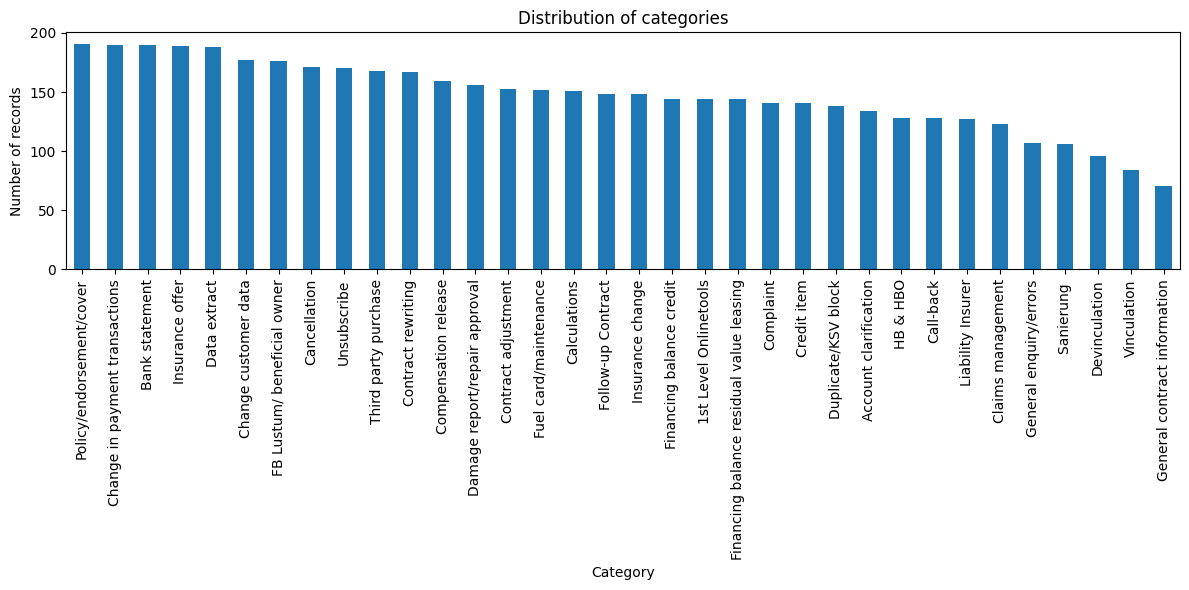

In [2]:
import matplotlib.pyplot as plt

# Counting number of records for each label
class_counts = df['category'].value_counts()

max_count = class_counts.max()
min_count = class_counts.min()

imbalance_ratio = max_count / min_count
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

std = class_counts.std()
mean = class_counts.mean()

print(f"Mean count: {mean:.2f}")
print(f"Standard deviation: {std:.2f}")

plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title("Distribution of categories")
plt.ylabel("Number of records")
plt.xlabel("Category")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
import os
import json
import joblib
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

RAW_CSV = "cat_emails_v2.csv"
OUTPUT_DIR = "prepared_data"
TRAIN_SIZE = 4500
TEST_SIZE = 500
RANDOM_STATE = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load source
df = pd.read_csv(RAW_CSV)

# Build text column
df['text'] = df['subject'].fillna('').astype(str) + " " + df['email'].fillna('').astype(str)
df = df[df['text'].str.strip() != '']  # drop empty texts

# Fit LabelEncoder on category
le = LabelEncoder()
df['category'] = df['category'].astype(str)
df['label_idx'] = le.fit_transform(df['category'].values)

# Save encoder and mapping
joblib.dump(le, os.path.join(OUTPUT_DIR, "label_encoder.pkl"))
label2idx = {str(c): int(i) for i, c in enumerate(le.classes_)}
with open(os.path.join(OUTPUT_DIR, "label2idx.json"), "w", encoding="utf-8") as f:
    json.dump(label2idx, f, ensure_ascii=False, indent=2)

# Ensure we have enough rows
if len(df) < TRAIN_SIZE + TEST_SIZE:
    raise ValueError(f"Not enough rows ({len(df)}) for requested split {TRAIN_SIZE}+{TEST_SIZE}")

# Stratified split: first sample TEST_SIZE for test, then take TRAIN_SIZE from remaining stratified by label_idx
# we do this by stratified splitting with test_size = TEST_SIZE / len(df)
test_frac = TEST_SIZE / len(df)
df_train_val, df_test = train_test_split(
    df,
    test_size=test_frac,
    stratify=df['label_idx'],
    random_state=RANDOM_STATE
)

# If df_train_val is larger than TRAIN_SIZE, downsample stratified to exact TRAIN_SIZE
if len(df_train_val) > TRAIN_SIZE:
    # compute fraction to keep
    keep_frac = TRAIN_SIZE / len(df_train_val)
    df_train, _ = train_test_split(
        df_train_val,
        train_size=keep_frac,
        stratify=df_train_val['label_idx'],
        random_state=RANDOM_STATE
    )
else:
    df_train = df_train_val.copy()

# Finalize outputs (text + label)
train_out = df_train[['text', 'label_idx']].rename(columns={'label_idx': 'label'})
test_out  = df_test[['text', 'label_idx']].rename(columns={'label_idx': 'label'})

train_out.to_csv(os.path.join(OUTPUT_DIR, "train.csv"), index=False)
test_out.to_csv(os.path.join(OUTPUT_DIR, "test.csv"), index=False)

print("Saved prepared datasets to", OUTPUT_DIR)
print("Train shape:", train_out.shape)
print("Test shape:", test_out.shape)
print("Number of classes:", len(le.classes_))

Saved prepared datasets to prepared_data
Train shape: (4500, 2)
Test shape: (500, 2)
Number of classes: 34
